In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import random
import shutil
import torch
import torchvision
import sklearn
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim  
#import datasets
#from datasets import load_dataset
from torchvision import transforms
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
source_dir = 'data'  # Directory containing your .wav files
output_dir = 'spectrogramOutputs'  # Directory to save spectrogram images
train_dir = os.path.join(output_dir, 'train')
valid_dir = os.path.join(output_dir, 'valid')
test_dir = os.path.join(output_dir, 'test')

# Create necessary directories
for folder in [train_dir, valid_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

def save_spectrogram(wav_path, img_path):
    # Load audio file
    y, sr = librosa.load(wav_path, sr=None)
    # Generate spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    # Plot spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D, x_axis='time', y_axis='log', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    # Save spectrogram as an image
    plt.savefig(img_path, bbox_inches='tight', pad_inches=0)
    plt.close()

def process_files(source_dir):
    files_by_class = {'B': [], 'I': [], 'F': []}

    # Iterate through all .wav files in source directory
    for filename in os.listdir(source_dir):
        if filename.endswith('.wav'):
            label = filename[0]  # B, I, or F from the filename
            if label in files_by_class:
                files_by_class[label].append(os.path.join(source_dir, filename))
    
    return files_by_class

def split_and_save(files_by_class):
    for label, files in files_by_class.items():
        # Split the files into train, test, and valid sets (80%, 10%, 10%)
        train_files, temp_files = train_test_split(files, test_size=0.3, random_state=42)
        valid_files, test_files = train_test_split(temp_files, test_size=0.4, random_state=42)

        # Save files to respective directories
        for folder, file_list in zip([train_dir, valid_dir, test_dir], [train_files, valid_files, test_files]):
            for file in file_list:
                # Create spectrogram and save it
                img_filename = os.path.splitext(os.path.basename(file))[0] + '.png'
                img_path = os.path.join(folder, label, img_filename)
                os.makedirs(os.path.dirname(img_path), exist_ok=True)
                save_spectrogram(file, img_path)

# Process the files and split them
files_by_class = process_files(source_dir)
split_and_save(files_by_class)

print("Preprocessing complete. Spectrogram images are saved.")

Preprocessing complete. Spectrogram images are saved.


Epoch [1/50], Loss: 0.9878, Train Accuracy: 50.85%
Validation Accuracy: 58.51%
Epoch [2/50], Loss: 0.8144, Train Accuracy: 63.84%
Validation Accuracy: 70.21%
Epoch [3/50], Loss: 0.7724, Train Accuracy: 66.10%
Validation Accuracy: 75.53%
Epoch [4/50], Loss: 0.6989, Train Accuracy: 70.34%
Validation Accuracy: 74.47%
Epoch [5/50], Loss: 0.7181, Train Accuracy: 66.38%
Validation Accuracy: 78.72%
Epoch [6/50], Loss: 0.6679, Train Accuracy: 74.86%
Validation Accuracy: 80.85%
Epoch [7/50], Loss: 0.6729, Train Accuracy: 72.60%
Validation Accuracy: 71.28%
Epoch [8/50], Loss: 0.6385, Train Accuracy: 75.99%
Validation Accuracy: 74.47%
Epoch [9/50], Loss: 0.6139, Train Accuracy: 78.53%
Validation Accuracy: 74.47%
Epoch [10/50], Loss: 0.6127, Train Accuracy: 77.12%
Validation Accuracy: 73.40%
Epoch [11/50], Loss: 0.6059, Train Accuracy: 77.12%
Validation Accuracy: 78.72%
Epoch [12/50], Loss: 0.5772, Train Accuracy: 77.40%
Validation Accuracy: 79.79%
Epoch [13/50], Loss: 0.5770, Train Accuracy: 76.5

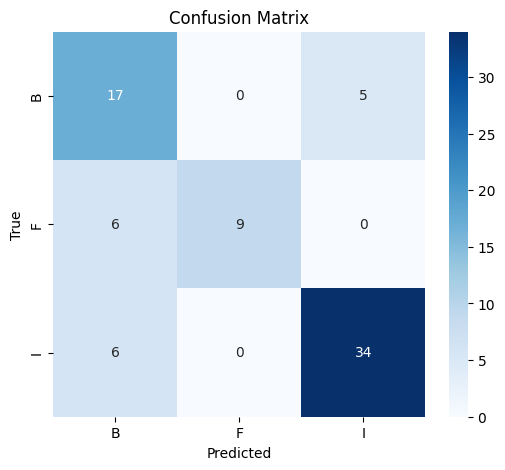

Test Accuracy: 77.92%


In [7]:
train_dir = 'pleasework/train'
valid_dir = 'pleasework/valid'
test_dir = 'pleasework/test'

# Hyperparameters
batch_size = 24
epochs = 50
learning_rate = 0.001

# Data transformations for MobileNetV2 input (resize and normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit MobileNetV2 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize based on ImageNet stats
])

# Load datasets using ImageFolder
train_dataset = ImageFolder(root=train_dir, transform=transform)
valid_dataset = ImageFolder(root=valid_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load pre-trained MobileNetV2 model and modify the final classifier layer
model = models.mobilenet_v2(pretrained=True)

# Freeze all layers except the last
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier layer to output 3 classes
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 3)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Validation
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    valid_accuracy = 100 * correct / total
    print(f"Validation Accuracy: {valid_accuracy:.2f}%")

# Test the model
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
test_accuracy = 100 * np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
print(f"Test Accuracy: {test_accuracy:.2f}%")

In [9]:
torch.save(model.state_dict(), "final_model.pth")
print("model saved")

model saved
